## Estimating bias in topology-change waiting distances in the MS-SMC'

The solution for the probability that a recombination event *does not change the topology* is exact, however, the expected waiting distance until a topology change event occurs calculated from this probability is not exact, it is approximation. This is because tree-changes (changes to coalescent times but not the topology) can occur during the waiting distance until a topology change. Here we investigate potential biases from this approximation. 


### Approach 1: Analytical solution/approximation
1. Simulate many unlinked genealogies (each for a single site).
2. Calculate `Prob(x-unchanged | S,G)` under MS-SMC' w/ bias for each one.
3. Calculate the `E[waiting distance to x-change]` from each prob.

### Approach 2: Estimation from simulations (slow) 
1. Simulate many unlinked loci of long length and get distance to first x-change event in each.
2. Simulate many unlinked loci of long length and get proportion where the first event is of type x.

In [1]:
from concurrent.futures import ProcessPoolExecutor
from typing import Tuple
import numpy as np
import pandas as pd
import ipcoal
import toyplot, toyplot.svg, toyplot.png
import toytree
from scipy import stats

### Parameters

In [23]:
RECOMB = 2e-9
NSPECIES = 8
NSAMPLES = 1    # samples per species
SPECIES_TREE_HEIGHT = 1e6
NEFF_MIN = 50_000
NEFF_MAX = 500_000
NEFF_VALS = 10
SEED = 123
NLOCI = 4       # very small, increased below after testing
NAME = f"{NSPECIES}-tips"

In [10]:
# get a balanced species tree
sptree = toytree.rtree.baltree(NSPECIES)
sptree = sptree.mod.edges_scale_to_root_height(treeheight=SPECIES_TREE_HEIGHT, include_stem=True)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td45bce34a29044f79cc2ddd5ae25f12d"> 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 r0 r1 r2 r3 r4 r5 r6 r7 0 250000 500000 750000

### Approach 1: get `Prob(x | S,G)` and `E[waiting distance]` under MS-SMC':

This uses the method we describe in the paper as our analytical solution for the probability of a topology change given a species tree, genealogy, and recombination rate. The expected waiting distance is then calculated from this probability. Here we return arrays for the probability of topology-unchanged, and the expected waiting distance until topology change, for many genealogies. The results will be compared with simulated expectations below.

In [14]:
def get_analytical_arrays(sptree: toytree.ToyTree, neff: int, seed: int, **kwargs) -> Tuple:
    """Return Prob(x-change | S,G) and E[waiting-distance] for many genealogies
    where x is either a tree-change or topology-change event.
    
    This uses some global variables (see above).
    
    Parameters
    ----------
    sptree: ToyTree
        A species tree with edge lengths in units of generations
    neff: int
        A diploid effective population size applied to all sptree edges.
    """
    # init a coalescent model using the species tree and diploid Ne value
    model = ipcoal.Model(sptree, Ne=neff, seed_trees=seed, recomb=RECOMB, nsamples=NSAMPLES)
    
    # simulate NLOCI unlinked genealogies
    model.sim_trees(nloci=NLOCI, nsites=1)
    imap = model.get_imap_dict()
    
    # load the first genealogy of every locus as a multitree
    mtree = toytree.mtree(model.df[model.df.tidx == 0].genealogy)
    
    # get Prob(x-change); this func currently takes sptree w/ haploid Ne
    stree = sptree.set_node_data("Ne", default=neff)
    topo_probs = np.array([
        ipcoal.smc.get_probability_of_topology_change(stree, i, imap)
        for i in mtree
    ])
    tree_probs = np.array([
        ipcoal.smc.get_probability_of_tree_change(stree, i, imap)
        for i in mtree
    ])
    
    # get sum branch lengths of each genealogy
    sumlens = np.array([sum(b.dist for b in i if not b.is_root()) for i in mtree])

    # get rate parameters
    topo_rates = sumlens * topo_probs * RECOMB
    tree_rates = sumlens * tree_probs * RECOMB
    
    # get waiting distances
    return (
        tree_probs, 
        topo_probs, 
        np.array([stats.expon.freeze(scale=1 / i).mean() for i in tree_rates]),
        np.array([stats.expon.freeze(scale=1 / i).mean() for i in topo_rates]),
    )

Examples: the probabilities of tree-change or higher, and their waiting-distances lower, than the same calculations for a topology-change event. 

In [15]:
NLOCI = 10

In [16]:
get_analytical_arrays(sptree, neff=50_000, seed=123)

(array([0.397933  , 0.38214271, 0.40141655, 0.40393901, 0.40644841,
        0.38702377, 0.36372906, 0.39654064, 0.39907936, 0.38524732]),
 array([0.01734152, 0.0374387 , 0.02642158, 0.10590528, 0.06516079,
        0.13253351, 0.01831428, 0.14019028, 0.01785414, 0.02129697]),
 array([277.68683661, 322.81579698, 279.65686062, 278.00228167,
        279.59570041, 315.50331861, 360.30757297, 292.39288281,
        253.40756447, 306.99261288]),
 array([6372.03417654, 3295.03186279, 4248.75783514, 1060.34341267,
        1744.01232936,  921.33138988, 7155.85598007,  827.05919571,
        5664.21593394, 5553.28256864]))

### Approach 2: get waiting distances to event x estimated from simulations:

The expected waiting distance for a topology-change under a given MSC model can also be estimated by using simulations. Here we simulate NLOCI tree sequences that each include
at least one recombination event. The first recombination event at each locus can be 
either a no-change, tree-change not affecting topology, or topology-change event. 
For each locus the probability that one of these three events occurs first should be
equal to their relative probability. Therefore, we simply compute the distance until a topology-change event occurs for each locus.

In [17]:
def get_sim_arrays(sptree: toytree.ToyTree, neff: int, nsites: int, seed: int) -> Tuple:
    """Return the proportion of NLOCI simulated tree-sequences that contained a 
    specified event type (tree or topo).
    
    This raises an exception if no events occurred. The nsites arg is used to 
    specify the length of simulated tree-sequences.
    """
    model = ipcoal.Model(
        sptree, Ne=neff, seed_trees=seed, nsamples=NSAMPLES, recomb=RECOMB,
        record_full_arg=True, ancestry_model="smc_prime")
    
    events = np.zeros(NLOCI, dtype=int)
    tree_dist = np.zeros(NLOCI, dtype=int)
    topo_dist = np.zeros(NLOCI, dtype=int)    
    
    # simulate a bunch of long tree-sequences
    for lidx in range(NLOCI):
        # get ts
        ts = next(model._get_tree_sequence_generator(nsites=nsites))

        # get iterators over trees and positions
        trees = ts.trees()
        positions = ts.breakpoints()
        
        # parse first tree
        _ = next(positions)
        t0 = next(trees)
        tlen0 = float(t0.total_branch_length)
        tidx0 = (
            toytree.tree(t0.as_newick())
            .mod.remove_unary_nodes()
            .get_topology_id(exclude_root=False)
        )

        # parse next tree one at a time until tree and topo changes
        this_tree = this_topo = None
        for idx in range(1, 99999999):
            pos = next(positions)
            t1 = next(trees)
            
            # get diff in branch lengths. This will be checked
            # to be > 0.1 to detect a tree-change, to avoid floating
            # point precision errors counting as tree-changes.
            diff = abs(tlen0 - t1.total_branch_length)
            
            # record first event type ----------------------
            if idx == 1:
                if diff < 0.1:
                    events[lidx] = 0
                else:
                    tidx1 = (
                        toytree.tree(t1.as_newick())
                        .mod.remove_unary_nodes()
                        .get_topology_id(exclude_root=False)
                    )
                    if tidx0 == tidx1:
                        events[lidx] = 1
                    else:
                        events[lidx] = 2

            # get distance to tree and topo change --------
            # no-change, check next tree 
            if diff < 0.1:
                continue

            # tree-change
            if not this_tree:
                tree_dist[lidx] = pos
                this_tree = 1

            # topo-change
            if not this_topo:
                tidx1 = (
                    toytree.tree(t1.as_newick())
                    .mod.remove_unary_nodes()
                    .get_topology_id(exclude_root=False)
                )
                if tidx0 != tidx1:
                    topo_dist[lidx] = pos
                    this_topo = 1

            # end loop
            if this_tree and this_topo:
                break

    # count proportion of events of requested type
    tree_prop = events[events != 0].size / NLOCI
    topo_prop = events[events == 2].size / NLOCI
    return tree_prop, topo_prop, tree_dist, topo_dist

In [18]:
NLOCI = 10

In [20]:
get_sim_arrays(sptree, 100_000, 5e5, seed=123)

(0.5,
 0.2,
 array([ 79,  43, 249,  25,  73, 460,   3,  30, 224, 209]),
 array([ 559,   43,  249,  372, 1031,  532, 1613,   30, 2466,  293]))

## ----

## Compare results of the two methods

In [21]:
# get array to store results of all reps
NLOCI = 100
NREPS = 100
res = np.zeros((NLOCI * NREPS, NEFF_VALS, 8))

# Ne values to test over
nes = np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int)

In [22]:
# run jobs in parallel to fill array
rasyncs = {}
with ProcessPoolExecutor(max_workers=50) as pool:
    
    # apply a different seed to each rep
    rng = np.random.default_rng(SEED)
    for rep in range(NREPS):
        seed = rng.integers(1e9)
        
        # apply same seed for each diff value of Ne
        for nidx in range(res.shape[1]):

            # get tree-change results
            kwargs = {"sptree": sptree, "neff": nes[nidx], "nsites": int(550000 - nes[nidx]), "seed": seed}
            rasyncs[(nidx, 'smc', rep)] = pool.submit(get_analytical_arrays, **kwargs)
            rasyncs[(nidx, 'sim', rep)] = pool.submit(get_sim_arrays, **kwargs)

# collect results into large res array
for key, future in rasyncs.items():
    nidx, name, rep = key
    ival = slice(NLOCI * rep, NLOCI * (rep + 1))
    if name == 'smc':
        tree_prob, topo_prob, tree_dist, topo_dist = future.result()
        res[ival, nidx, 0] = tree_prob
        res[ival, nidx, 1] = topo_prob
        res[ival, nidx, 2] = tree_dist
        res[ival, nidx, 3] = topo_dist
    else:
        tree_prob, topo_prob, tree_dist, topo_dist = future.result()
        res[ival, nidx, 4] = tree_prob
        res[ival, nidx, 5] = topo_prob
        res[ival, nidx, 6] = tree_dist
        res[ival, nidx, 7] = topo_dist      

In [26]:
# summarize results into a dataframe
data = pd.DataFrame(
    data={
        'tree_smc_prob': res[:, :, 0].mean(axis=0),
        'topo_smc_prob': res[:, :, 1].mean(axis=0),
        'tree_smc_dist': res[:, :, 2].mean(axis=0),
        'topo_smc_dist': res[:, :, 3].mean(axis=0),       
        'tree_sim_prob': res[:, :, 4].mean(axis=0),
        'topo_sim_prob': res[:, :, 5].mean(axis=0),
        'tree_sim_dist': res[:, :, 6].mean(axis=0),
        'topo_sim_dist': res[:, :, 7].mean(axis=0),
        
        'tree_smc_prob_CI95':  tuple(zip(
            np.percentile(res[:, :, 0], 2.5, axis=0).round(5),
            np.percentile(res[:, :, 0], 97.5, axis=0).round(5),
        )),
        'topo_smc_prob_CI95':  tuple(zip(
            np.percentile(res[:, :, 1], 2.5, axis=0).round(5),
            np.percentile(res[:, :, 1], 97.5, axis=0).round(5),
        )),
        
        'tree_smc_dist_CI95':  tuple(zip(
            np.percentile(res[:, :, 2], 2.5, axis=0).round(5),
            np.percentile(res[:, :, 2], 97.5, axis=0).round(5),
        )),
        'topo_smc_dist_CI95':  tuple(zip(
            np.percentile(res[:, :, 3], 2.5, axis=0).round(5),
            np.percentile(res[:, :, 3], 97.5, axis=0).round(5),
        )),
    },
    index=nes,
)
data['nsamples'] = NLOCI * NREPS

In [142]:
# show the dataframe of results
data

,tree_smc_prob,topo_smc_prob,tree_smc_dist,topo_smc_dist,tree_sim_prob,topo_sim_prob,tree_sim_dist,topo_sim_dist,tree_smc_prob_CI95,topo_smc_prob_CI95,tree_smc_dist_CI95,topo_smc_dist_CI95,nsamples
50000,0.392366,0.056838,299.916475,3608.511019,0.3996,0.0591,295.6935,3294.0685,"(0.36743, 0.42578)","(0.01684, 0.18341)","(238.15978, 354.56345)","(583.26876, 7134.67795)",400
100000,0.545992,0.204932,185.375369,576.355166,0.5455,0.2026,183.9866,575.4316,"(0.52914, 0.56315)","(0.08884, 0.35684)","(144.71992, 221.83899)","(253.5778, 1184.25206)",400
150000,0.619405,0.304690,145.208343,316.357443,0.6124,0.3003,148.8412,320.2081,"(0.59364, 0.63901)","(0.16613, 0.44646)","(108.85838, 179.41647)","(179.73648, 581.83052)",400
200000,0.663588,0.366547,122.807762,231.760069,0.6643,0.3648,123.7240,235.5862,"(0.62478, 0.68814)","(0.21932, 0.50178)","(89.53545, 156.13556)","(146.14305, 377.71323)",400
250000,0.693405,0.406958,108.020352,189.770293,0.6947,0.4114,108.8961,188.7383,"(0.64269, 0.72184)","(0.24987, 0.5412)","(76.79677, 140.91002)","(124.16641, 295.00296)",400
300000,0.715136,0.434123,97.193498,164.161156,0.7190,0.4337,98.2899,165.7981,"(0.65526, 0.74745)","(0.2683, 0.56948)","(67.44972, 130.22282)","(109.06327, 246.80178)",400
350000,0.731076,0.452522,88.575858,146.304000,0.7306,0.4469,89.7001,148.5690,"(0.65957, 0.76651)","(0.27364, 0.59196)","(59.97468, 120.75922)","(97.72644, 215.28256)",400
400000,0.743960,0.466292,81.826224,133.231143,0.7470,0.4660,83.4087,136.3386,"(0.66497, 0.78184)","(0.28048, 0.61049)","(54.39641, 113.53829)","(89.27743, 194.57147)",400
450000,0.754058,0.475902,76.221021,123.178242,0.7556,0.4686,75.2070,124.6542,"(0.66673, 0.79426)","(0.28062, 0.62641)","(49.59562, 107.37739)","(82.1159, 178.39059)",400
500000,0.762197,0.482774,71.497825,115.147772,0.7634,0.4838,71.4207,114.6248,"(0.66847, 0.80537)","(0.27697, 0.63928)","(46.02125, 102.22639)","(76.3751, 167.20987)",400


In [28]:
# save the dataframe
data.to_csv(f"./validation-topology-10K-{NAME}.csv")

In [29]:
# save the full array
np.save(f"./validation-topology-10K-{NAME}.npy", res)

### Plot the Prob(topology-unchanged) expectation versus approximation
We expect bias to be greatest at low Ne, where many tree changes happen for every topology-change.

In [143]:
def plot_probs(data, topo: bool=False):
    
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    color = toytree.color.COLORS2[0]
    canvas = toyplot.Canvas(width=350, height=300)
    
    # setup axes
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "P(topo-change | S,G)" if topo else "P(tree-change | S,G)"
    axb.y.domain.max = 1
    axb.y.domain.min = 0
    axb.x.domain.min = 0
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 5
        ax.ticks.far = 0
        ax.ticks.style["stroke-width"] = 2
        ax.ticks.labels.offset = 10
        ax.ticks.labels.style["font-size"] = 14
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.spine.style["stroke-width"] = 2
        
    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        #np.linspace(0.5, 5, 5),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(50_000, 500_000, 4),
        (avgdist / (2 * np.linspace(50_000, 500_000, 4))).round(1),
    )
        
    # plot data
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "prob_CI95"]],
       [i[1] for i in data[smckey + "prob_CI95"]],
       opacity=0.33,
    )
    axb.plot(data.index, data[smckey + "prob"], stroke_width=2, color=color)
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "prob"], size=8, color=color),
        axb.scatterplot(data.index, data[simkey + "prob"], size=7, marker='s', **style),
    ]
    return canvas

In [144]:
canvas = plot_probs(data, topo=False)
#toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/bias-{NAME}-tree-probs.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t0026e3a76fb249e08feaeebe69be625a"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(tree-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

In [145]:
canvas = plot_probs(data, topo=True)
#toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/bias-{NAME}-topo-probs.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tacbedc965b57484eb6a31d88dd0aeaf3"> 50000 200000 350000 500000 N e (diploid) 0.0 0.5 1.0 P(topo-change | S,G) 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

In [167]:
def plot_distances(data, topo: bool=False, log: bool=True):
    
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    color = toytree.color.COLORS2[0]
    canvas = toyplot.Canvas(width=350, height=300)
    
    # setup axes
    axb = canvas.cartesian(margin=65)
    axt = axb.share("y")#, yscale="log")
    axb.x.label.text = "N<sub>e</sub> (diploid)"
    axt.x.label.text = "Sptree edge lengths (coal units)"
    axb.y.label.text = "Distance to topo-change" if topo else "Distance to tree-change"
    axb.x.domain.min = 0
        
    if log:
        axt.y.scale = "log"
        axb.y.domain.min = 10
        axb.y.domain.max = 1e4
    else:
        axb.y.domain.min = 10
        axb.y.domain.max = 10000
    
    # style axes
    for ax in (axb.x, axt.x, axb.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 5
        ax.ticks.far = 0
        ax.ticks.style["stroke-width"] = 2
        ax.ticks.labels.offset = 10
        ax.ticks.labels.style["font-size"] = 14
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.spine.style["stroke-width"] = 2
        
    avgdist = np.min([i.dist for i in sptree if not i.is_root()])
    axb.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
    )
    axt.x.ticks.locator = toyplot.locator.Explicit(
        np.linspace(NEFF_MIN, NEFF_MAX, 4),
        (avgdist / (2 * np.linspace(NEFF_MIN, NEFF_MAX, 4))).round(1),
    )
        
    # plot data
    axb.fill(
       data.index,
       [i[0] for i in data[smckey + "dist_CI95"]],
       [i[1] for i in data[smckey + "dist_CI95"]],
       opacity=0.33,
    )
    axb.plot(data.index, data[smckey + "dist"], stroke_width=2, color=color)
    style = dict(opacity=0.8, color='black', mstyle={"stroke": "none"})
    marks = [
        axb.scatterplot(data.index, data[smckey + "dist"], size=8, color=color),
        axb.scatterplot(data.index, data[simkey + "dist"], size=7, marker='s', **style),
    ]
    return canvas

In [172]:
canvas = plot_distances(data, topo=False, log=True)
#toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/bias-{NAME}-tree-distances.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t72780b0bb9024c9da4753c70a47e0b49"> <polygon points="87.0,156.97745617396154 109.0,169.23672888595013 131.0,176.2444942044671 153.0,181.05361549413016 175.0,184.83056591746293 197.0,188.02445810144997 219.0,190.9151500989129 241.0,193.3176864844338 263.0,195.5915449851129 285.0,197.43235673697 285.0,177.79142861242656 263.0,176.58160553786706 241.0,175.20860022162378 219.0,173.69118304568428 197.0,171.83439790225646 175.0,169.89329366248927 153.0,167.3682299026724 131.0,163.9478025621982 109.0,158.72452017322775 87.0,147.18400867619297" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) 10 1 10 2 10 3 10 4 Distance to tree-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

In [173]:
canvas = plot_distances(data, topo=True, log=True)
#toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/bias-{NAME}-topo-distances.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2567b530e02e4f8b9a609ba93f836a48"> <polygon points="87.0,134.9341060849898 109.0,155.43369698631744 131.0,163.90394684674604 153.0,168.99590388057342 175.0,173.0064329377763 197.0,176.19821749341116 219.0,178.8993155525364 241.0,181.12463814007094 263.0,183.1824554273525 285.0,184.96606512654023 285.0,165.68182514377278 263.0,164.08892329445013 241.0,161.95218093143924 219.0,159.46283188243234 197.0,156.10026370155188 175.0,151.70983882803188 153.0,145.6274755066604 131.0,134.99486508582913 109.0,117.5048315649664 87.0,73.30878545009483" style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;opacity:0.33;stroke:none"> 50000 200000 350000 500000 N e (diploid) 10 1 10 2 10 3 10 4 Distance to topo-change 2.5 0.6 0.4 0.2 Sptree edge lengths (coal units)

### Plot observed waiting distance / expected waiting distance 

This is shown for every replicate. In the tree-change scenario the ratio of 

In [134]:
def plot_bias(data, topo: bool=False, nidx: int=0):
    
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    odx = 3 if topo else 2
    sdx = 7 if topo else 6
    color = toytree.color.COLORS2[0]
    
    canvas = toyplot.Canvas(width=350, height=300)
    
    ax0 = canvas.cartesian(bounds=(65, 250, 65, 300-65))#yscale='log')
    ax1 = canvas.cartesian(bounds=(255, 350-65, 65, 300-65))#yscale='log')
    ax0.label.text = f"Log waiting distance to {'topo' if topo else 'tree'}-change"
    ax0.label.offset = 25
    ax0.x.label.text = "Expected "
    ax0.y.label.text = "Observed/Expected"

    for ax in (ax0.x, ax0.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 5
        ax.ticks.far = 0
        ax.ticks.style["stroke-width"] = 2
        ax.ticks.labels.offset = 10
        ax.ticks.labels.style["font-size"] = 14
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.spine.style["stroke-width"] = 2

    # scatterplot observations
    edata = np.log(res[:, nidx, odx])#[::10]
    odata = np.log(res[:, nidx, sdx])#[::10]
    ratio = odata / edata
    ax0.scatterplot(edata, ratio, opacity=100 / edata.size, size=6,)
    ax0.hlines(1, style={"stroke-dasharray": "4,4", "stroke-width": 2})
    
    # get histogram of errors
    bins = 25
    mag, pos = np.histogram(ratio, bins=bins)
    ax1.bars(
        pos[:-1] + 0.01, pos[1:] - 0.01, (mag/mag.max()) / 2, 
        along='y', 
        baseline=np.repeat(5.5, bins),
        style={'stroke': "none", "fill": color},
    )
    ax1.show = False
    return canvas

In [135]:
canvas = plot_bias(data, topo=1, nidx=0)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="300.0px" viewBox="0 0 350.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t4091f50274434d5dad42a5c21132ce1a"> <g style="fill:rgb(40%,76.1%,64.7%);fill-opacity:1.0;o

In [153]:
toyplot.config.autorender = False
for topo in (0, 1):
    for nidx in range(10):
        canvas = plot_bias(data, topo=topo, nidx=nidx)
        fname = f"bias-{NAME}-{'topo' if topo else 'tree'}-{nidx}.svg"
        toyplot.svg.render(canvas, f"../manuscript/figures/alternatives/{fname}")
toyplot.config.autorender = True

### Stacked histograms

In [130]:
def plot_stacked_bias(data, topo: bool=False):
    
    smckey = "topo_smc_" if topo else "tree_smc_"
    simkey = "topo_sim_" if topo else "tree_sim_"
    odx = 3 if topo else 2
    sdx = 7 if topo else 6
    color = toytree.color.COLORS2[0]
    
    canvas = toyplot.Canvas(width=350, height=300)
    
    ax0 = canvas.cartesian(margin=65)
    ax0.label.text = f"Log waiting distance to {'topo' if topo else 'tree'}-change"
    ax0.label.offset = 25
    #ax0.x.label.text = "Expected "
    ax0.y.label.text = "Observed/Expected"

    for ax in (ax0.x, ax0.y):
        ax.domain.show = False
        ax.ticks.show = True
        ax.ticks.near = 5
        ax.ticks.far = 0
        ax.ticks.style["stroke-width"] = 2
        ax.ticks.labels.offset = 10
        ax.ticks.labels.style["font-size"] = 14
        ax.label.offset = 35
        ax.label.style["font-size"] = 16
        ax.spine.style["stroke-width"] = 2

    # scatterplot observations
    nes = np.linspace(NEFF_MIN, NEFF_MAX, NEFF_VALS).astype(int)
    for nidx, neff in enumerate(nes):
        edata = np.log(res[:, nidx, odx])#[::10]
        odata = np.log(res[:, nidx, sdx])#[::10]
        ratio = odata / edata
        #ax0.scatterplot(edata, ratio, opacity=100 / edata.size, size=6,)
        #ax0.hlines(1, style={"stroke-dasharray": "4,4", "stroke-width": 2})
    
        # get histogram of errors
        bins = 30
        mag, pos = np.histogram(ratio, bins=bins)
#         ax0.bars(
#             pos[:-1] + 0.01, pos[1:] - 0.01, (mag/mag.max()), 
#             along='y', 
#             baseline=np.repeat(nidx, bins),
#             style={'stroke': "none", "fill": color},
#         )
        ax0.fill(
            pos[1:], np.repeat(nidx, mag.size), nidx + (mag/mag.max()), 
            along='y',
            style={'stroke': "none", "fill": color, "fill-opacity": 0.3},
        )
    return canvas

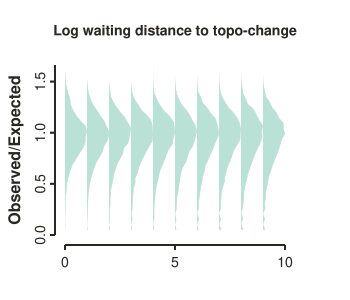

In [131]:
plot_stacked_bias(data, topo=True)